# Home Exercise on Named Entity Recognition

Implement a **Recurrent Neural Network model** (**[Bidirectional LSTM-CRF Models for Sequence Tagging](https://arxiv.org/pdf/1508.01991)**) to extract named entities from text. Entity labels are encoded using the **BIO notation**, where each entity label is assigned a **B** (Beginning) or **I** (Inside) tag. The **B-** tag indicates the beginning of an entity, while the **I-** tag marks words inside the same entity.

These tags help identify multi-word entities. For example, in the phrase **"World War II"**, the labels would be: **(B-eve, I-eve, I-eve)**. Words that do not belong to any entity are labeled as **O** (Outside).

- **Data**: [Annotated GMB Corpus](https://www.kaggle.com/datasets/shoumikgoswami/annotated-gmb-corpus?select=GMB_dataset.txt) *(the last 10% of rows serve as the test set).*

**Note**: Submit only a **single Jupyter Notebook file** that can handle all tasks, including data downloading, preprocessing, model training, and model evaluation. *(Submissions that do not follow the guidelines will receive a score of 0.)*

## Grading Criteria

For valid submissions, scores will be assigned based on the **leaderboard ranking** (**strictly greater**):

- **Top 25%** → **10 points**
- **25% - 50%** → **9.0 points**
- **50% - 75%** → **8.0 points**
- **75% - 100%** → **7.0 points**


link to the datasets that we would use

https://www.kaggle.com/datasets/shoumikgoswami/annotated-gmb-corpus

https://www.kaggle.com/datasets/abhinavwalia95/entity-annotated-corpus/data


In [ ]:
# %pip install git+https://www.github.com/keras-team/keras-contrib.git

In [ ]:
%pip install numpy pandas tensorflow==2.15.0 matplotlib scikit-learn tensorflow_addons kagglehub


In [ ]:
# !pip install --upgrade tensorflow tensorflow-addons

In [ ]:
import pandas as pd
import numpy as np
import gdown
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, TimeDistributed, Dropout, Input
from tensorflow.keras.models import Model
# from keras_crf import CRF
# from keras_contrib.layers import CRF
from tensorflow_addons.layers import CRF
import keras as k


In [ ]:
# https://drive.google.com/drive/folders/1GbEc7KGjuiByArwjt3CS69Lrk-ttJ4Ly?usp=sharing

# URL of the shared folder
folder_url = "https://drive.google.com/drive/folders/1GbEc7KGjuiByArwjt3CS69Lrk-ttJ4Ly?usp=sharing"

# Output directory where the folder will be saved
output_dir = "./NLP_Data_GDrive"

# Download the folder
gdown.download_folder(folder_url, output=output_dir, quiet=False, use_cookies=False)

Retrieving folder contents


Processing file 125vSHeQajcbRTMJiq4Hc5WPH-GcCxkVr annotated-gmb-corpus.zip
Processing file 1gTWviZN3RcBUzm--_ife7qCUuTb1H8lr GMB_dataset.txt


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=125vSHeQajcbRTMJiq4Hc5WPH-GcCxkVr
To: /content/NLP_Data_GDrive/annotated-gmb-corpus.zip
100%|██████████| 473k/473k [00:00<00:00, 6.26MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gTWviZN3RcBUzm--_ife7qCUuTb1H8lr
To: /content/NLP_Data_GDrive/GMB_dataset.txt
100%|██████████| 1.60M/1.60M [00:00<00:00, 14.1MB/s]
Download completed


['./NLP_Data_GDrive/annotated-gmb-corpus.zip',
 './NLP_Data_GDrive/GMB_dataset.txt']

In [ ]:
# Load dataset (Ensure file path is correct)
file_path = os.path.join(output_dir, "GMB_dataset.txt")  # Adjust file path if needed

# Check if files exist
if not os.path.exists(file_path):
    raise FileNotFoundError("File not found. Check the download process and file paths.")

# df = pd.read_csv(file_path, delimiter="\t", names=["Sentence#", "Word", "POS", "Tag"], skiprows=1)
df = pd.read_csv(file_path, delimiter="\t", names=["Sentence#", "Word", "POS", "Tag"], skiprows=1, encoding="latin1")

# Fill missing Sentence# values
df["Sentence#"] = df["Sentence#"].fillna(method="ffill")

# Display first few rows
df.head(20)
df.tail(20)

<ipython-input-12-144d2205f476>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Sentence#"] = df["Sentence#"].fillna(method="ffill")


,Sentence#,Word,POS,Tag
66141,2998.0,for,IN,O
66142,2998.0,an,DT,O
66143,2998.0,attempted,JJ,O
66144,2998.0,assassination,NN,O
66145,2998.0,of,IN,O
66146,2998.0,Saddam,NNP,B-per
66147,2998.0,.,.,O
66148,2999.0,The,DT,O
66149,2999.0,judge,NN,O
66150,2999.0,told,VBD,O


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66161 entries, 0 to 66160
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Sentence#  66161 non-null  float64
 1   Word       66161 non-null  object 
 2   POS        66161 non-null  object 
 3   Tag        66161 non-null  object 
dtypes: float64(1), object(3)
memory usage: 2.5+ MB


In [ ]:
# Count occurrences of each tag in the dataset
tag_counts = df["Tag"].value_counts()

# Print tag counts
print(tag_counts)

Tag
O        56217
B-geo     2070
B-org     1237
I-per     1234
B-gpe     1230
B-tim     1160
B-per     1107
I-org      926
I-geo      414
I-tim      334
B-art       53
B-eve       45
I-eve       37
I-gpe       34
I-art       34
B-nat       20
I-nat        9
Name: count, dtype: int64


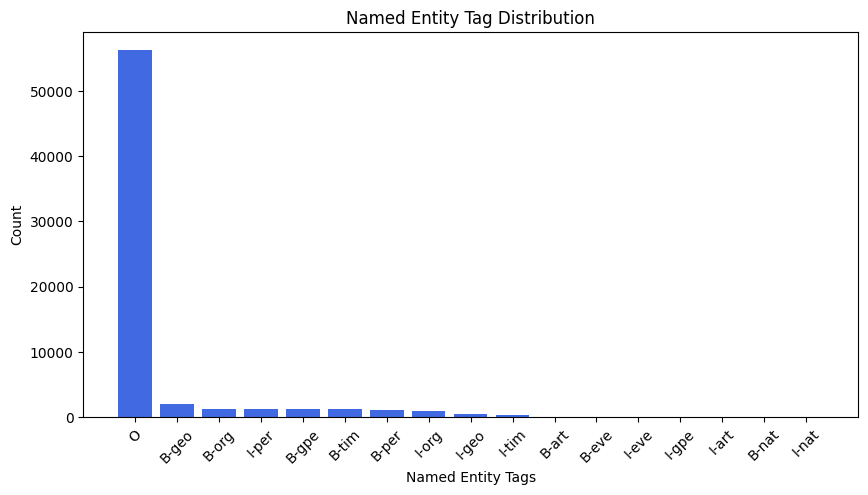

In [ ]:
# Sort tags by frequency for better visualization
tag_counts_sorted = tag_counts.sort_values(ascending=False)

# Plot bar chart
plt.figure(figsize=(10, 5))
plt.bar(tag_counts_sorted.index, tag_counts_sorted.values, color='royalblue')
plt.xlabel("Named Entity Tags")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.title("Named Entity Tag Distribution")
plt.show()



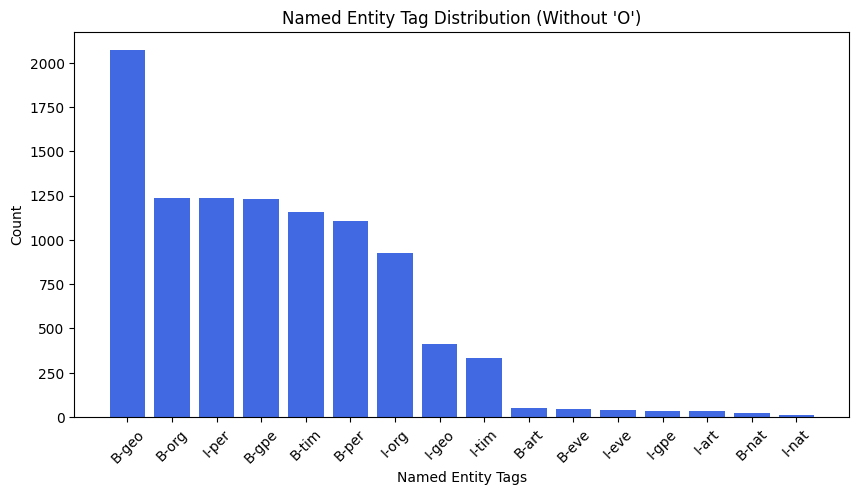

In [ ]:
tag_counts_filtered = tag_counts.drop("O")

tag_counts_sorted = tag_counts_filtered.sort_values(ascending=False)
plt.figure(figsize=(10, 5))
plt.bar(tag_counts_sorted.index, tag_counts_sorted.values, color='royalblue')
plt.xlabel("Named Entity Tags")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.title("Named Entity Tag Distribution (Without 'O')")
plt.show()

In [ ]:
# Group words by sentences
sentences = df.groupby("Sentence#")["Word"].apply(list).values
tags = df.groupby("Sentence#")["Tag"].apply(list).values

# Create a vocabulary and tag index
words = list(set(df["Word"].values))
words.append("PAD")  # Add padding token
n_words = len(words)

tags_set = list(set(df["Tag"].values))
n_tags = len(tags_set)

# Word-to-index and index-to-word mappings
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in word2idx.items()}

# Tag-to-index and index-to-tag mappings
tag2idx = {t: i for i, t in enumerate(tags_set)}
idx2tag = {i: t for t, i in tag2idx.items()}

print(f"Vocabulary size: {n_words}, Number of Tags: {n_tags}")


Vocabulary size: 8767, Number of Tags: 17


In [ ]:
MAX_LEN = 75  # Adjust as needed

# Convert words to indices and pad sequences
X = [[word2idx[w] for w in s] for s in sentences]
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert tags to indices and pad sequences
y = [[tag2idx[t] for t in s] for s in tags]
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["O"])

# Convert labels to categorical (one-hot encoding)
y = [to_categorical(i, num_classes=n_tags) for i in y]

# Train-test split (90% train, 10% test)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y, dtype=np.float32)

# Keep the last 10% of rows for testing (instead of random splitting)
split_index = int(len(X) * 0.9)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Convert y_train and y_test to float32
# y_train = np.array(y_train).astype(np.float32)
# y_test = np.array(y_test).astype(np.float32)

# Convert y_train from one-hot encoding (num_samples, MAX_LEN, n_tags) to (num_samples, MAX_LEN)
y_train = np.argmax(y_train, axis=-1)  # Convert one-hot to integer labels
y_test = np.argmax(y_test, axis=-1)

# Print shapes again
print(f"X_train shape: {X_train.shape}")  # Should be (num_samples, MAX_LEN)
print(f"y_train shape: {y_train.shape}")  # Should be (num_samples, MAX_LEN)
print(f"X_test shape: {X_test.shape}")  # Should be (num_samples, MAX_LEN)
print(f"y_test shape: {y_test.shape}")  # Should be (num_samples, MAX_LEN)

print(f"Training Samples: {len(X_train)}, Testing Samples: {len(X_test)}")


X_train shape: (2699, 75)
y_train shape: (2699, 75)
X_test shape: (300, 75)
y_test shape: (300, 75)
Training Samples: 2699, Testing Samples: 300


In [ ]:
# Check unique values in y_train
unique_labels = np.unique(y_train)
print("Unique Labels in y_train:", unique_labels)

Unique Labels in y_train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [ ]:
X_train

array([[7203, 6262, 7171, ..., 8766, 8766, 8766],
       [1429, 6262, 8303, ..., 8766, 8766, 8766],
       [ 708, 7095, 6719, ..., 8766, 8766, 8766],
       ...,
       [  66, 6029, 3310, ..., 8766, 8766, 8766],
       [1547, 1792,   19, ..., 8766, 8766, 8766],
       [1547, 1792, 6029, ..., 8766, 8766, 8766]], dtype=int32)

In [ ]:
%pip install tensorflow-addons


In [ ]:
import tensorflow_addons as tfa
from tensorflow_addons.text import crf_log_likelihood

In [ ]:
import tensorflow.keras.backend as K

def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        # One-hot encode y_true to match the shape of y_pred
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
        y_pred = K.clip(y_pred, 1e-9, 1.0)  # Avoid log(0)

        ce_loss = -y_true * K.log(y_pred)  # Standard Crossentropy
        weight = K.pow(1 - y_pred, gamma)  # Apply focal weight
        return alpha * weight * ce_loss

    return loss

In [ ]:
EMBEDDING_DIM = 200  # Embedding size

# Define Model
input_layer = Input(shape=(MAX_LEN,))

# Embedding Layer
embedding = Embedding(input_dim=n_words, output_dim=EMBEDDING_DIM, input_length=MAX_LEN)(input_layer)

# BiLSTM Layer
bi_lstm = Bidirectional(LSTM(units=64, return_sequences=True, dropout=0.5, recurrent_dropout=0.25))(embedding)

# TimeDistributed Dense Layer
dense = TimeDistributed(Dense(n_tags, activation="relu"))(bi_lstm)

# CRF Layer
crf_layer = tfa.layers.CRF(n_tags)

# ----------
# Extract the correct output from CRF (we only need (None, 70, 17))
crf_output = crf_layer(dense)[1]  # Select (None, 50, 17) -> Full logits

# Compile Model with Correct Output
model = Model(input_layer, crf_output)

adam = k.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)

# model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"], run_eagerly=True)
model.compile(optimizer=adam, loss=focal_loss(alpha=0.25, gamma=2.0), metrics=["accuracy"], run_eagerly=True)

# --------

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 75)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 75, 200)           1753400   
                                                                 
 bidirectional_4 (Bidirecti  (None, 75, 128)           135680    
 onal)                                                           
                                                                 
 time_distributed_4 (TimeDi  (None, 75, 17)            2193      
 stributed)                                                      
                                                                 
 crf_4 (CRF)                 [(None, 75),              629       
                              (None, 75, 17),                    
                              (None,),                     

In [ ]:
print(f"X_train shape: {X_train.shape}")  # Should be (num_samples, MAX_LEN)
print(f"y_train shape: {y_train.shape}")  # Should be (num_samples, MAX_LEN)


X_train shape: (2699, 75)
y_train shape: (2699, 75)


In [ ]:
import os
import warnings
import tensorflow as tf

# Suppress TensorFlow and other warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TF logs (1=INFO, 2=WARNING, 3=ERROR)
warnings.filterwarnings("ignore")  # Ignore all Python warnings

# Disable TensorFlow eager execution warnings (if needed)
tf.get_logger().setLevel('ERROR')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define checkpoint to save the best model
checkpoint = ModelCheckpoint("best_crf_model.h5", monitor="val_accuracy", save_best_only=True, mode="max")

# Train Model
EPOCHS = 2
BATCH_SIZE = 128

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    verbose=1,
    callbacks=[checkpoint]
)


Epoch 1/2
19/19 [==============================] - 77s 4s/step - loss: 0.0316 - accuracy: 0.8118 - val_loss: 0.0126 - val_accuracy: 0.9532
Epoch 2/2
19/19 [==============================] - 71s 4s/step - loss: 0.0073 - accuracy: 0.9555 - val_loss: 0.0033 - val_accuracy: 0.9534


In [ ]:
hist = pd.DataFrame(history.history)

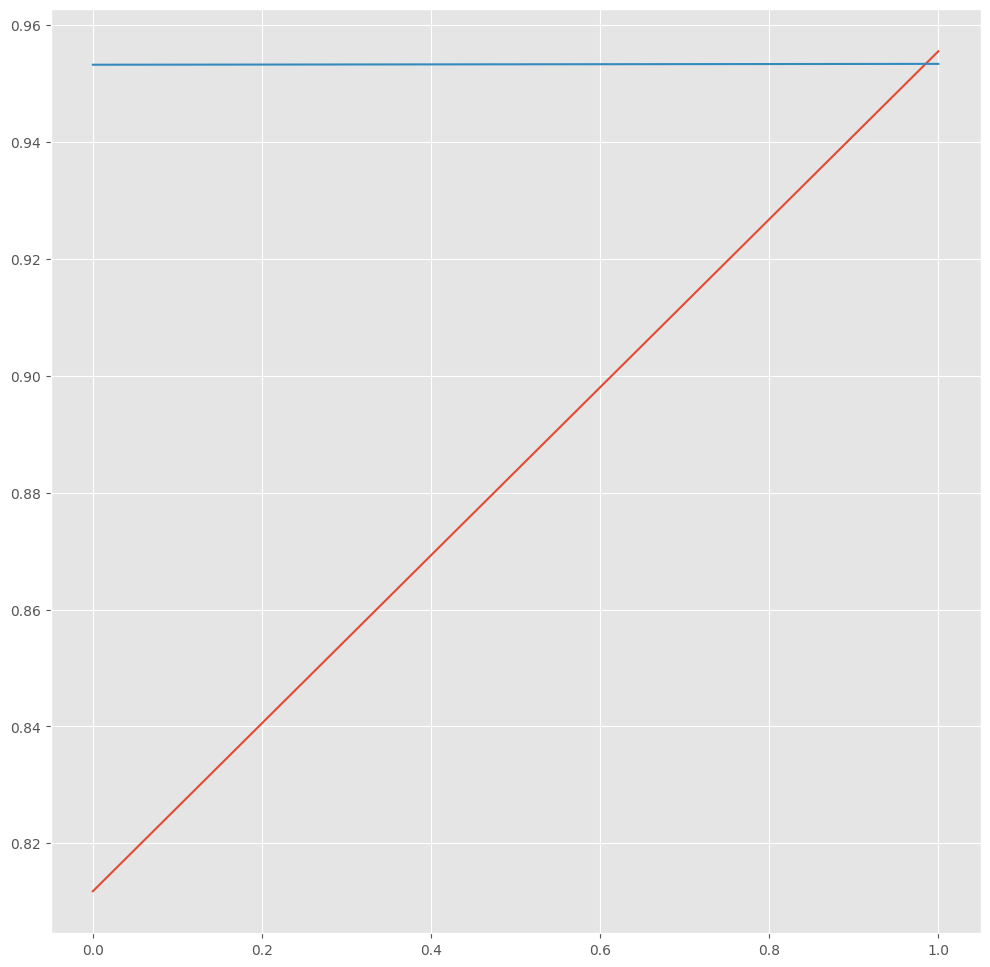

In [ ]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.show()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out

In [ ]:
# Evaluate on Test Set
test_pred = model.predict(X_test, verbose=1)


10/10 [==============================] - 18s 2s/step


In [ ]:
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

In [ ]:
# classification_report(test_labels, pred_labels)

# Flatten the lists
test_labels_flat = [item for sublist in test_labels for item in sublist]
pred_labels_flat = [item for sublist in pred_labels for item in sublist]

# Generate the classification report using the flattened lists
print(classification_report(test_labels_flat, pred_labels_flat))

              precision    recall  f1-score   support

       I-eve       0.00      0.00      0.00   22500.0
           O       0.00      0.00      0.00       0.0

    accuracy                           0.00   22500.0
   macro avg       0.00      0.00      0.00   22500.0
weighted avg       0.00      0.00      0.00   22500.0



In [ ]:
# Convert predictions to tag labels (apply argmax)
test_pred = np.argmax(test_pred, axis=-1)  # Convert logits to integer labels

# Convert predicted indices to tags
pred_tags = [[idx2tag[tag] for tag in sentence] for sentence in test_pred]

# Convert true indices to tags (no need for argmax, y_test is already integer)
true_tags = [[idx2tag[tag] for tag in sentence] for sentence in y_test]

# Calculate accuracy
accuracy = np.mean([1 if pred == true else 0 for p, t in zip(pred_tags, true_tags) for pred, true in zip(p, t)])
print(f"Test Accuracy: {accuracy:.4f}")

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Run inference on test dataset
test_pred = model.predict(X_test)

# Convert logits to predicted class indices
test_pred = np.argmax(test_pred, axis=-1)  # Shape: (num_samples, MAX_LEN)

# Convert true labels from test set (already in integer format)
y_test_flat = y_test.flatten()  # Flatten from (num_samples, MAX_LEN) -> (total tokens)
y_pred_flat = test_pred.flatten()  # Flatten predictions similarly

# ✅ Remove "O" tokens from both `y_test` and `y_pred`
# mask = (y_test_flat != tag2idx["O"])  # Ignore "O" tokens if needed
# y_test_flat = y_test_flat[mask]  # Apply mask
# y_pred_flat = y_pred_flat[mask]  # Apply same mask to predictions

# ✅ Ensure `y_pred_flat` is an integer type
y_pred_flat = y_pred_flat.astype(int)

# ✅ Compute Classification Report (Precision, Recall, F1-Score)
print("Named Entity Recognition - Classification Report:\n")
print(classification_report(
    y_test_flat, y_pred_flat,
    labels=list(range(n_tags)),  # Include all class indices
    target_names=list(tag2idx.keys()),  # Map indices to class names
    zero_division=0  # Handle missing classes gracefully
))

# ✅ Compute Overall Accuracy
accuracy = accuracy_score(y_test_flat, y_pred_flat)

# ✅ Compute Macro & Weighted Precision, Recall, and F1-score
precision = precision_score(y_test_flat, y_pred_flat, average="macro", zero_division=0)
recall = recall_score(y_test_flat, y_pred_flat, average="macro", zero_division=0)
f1 = f1_score(y_test_flat, y_pred_flat, average="macro", zero_division=0)

# ✅ Print All Metrics
print("\n🔹 **Final Model Performance Metrics:**")
print(f"⚡ Test Accuracy: {accuracy:.4f}")
print(f"📌 Macro Precision: {precision:.4f}")
print(f"📌 Macro Recall: {recall:.4f}")
print(f"📌 Macro F1-Score: {f1:.4f}")


10/10 [==============================] - 8s 808ms/step
Named Entity Recognition - Classification Report:

              precision    recall  f1-score   support

       B-per       0.00      0.00      0.00       144
       B-org       0.00      0.00      0.00       101
           O       0.93      1.00      0.97     13999
       I-geo       0.00      0.00      0.00        34
       B-eve       0.00      0.00      0.00         4
       B-nat       0.00      0.00      0.00         1
       I-art       0.00      0.00      0.00         0
       I-gpe       0.00      0.00      0.00         2
       I-nat       0.00      0.00      0.00         0
       B-tim       0.00      0.00      0.00       113
       B-gpe       0.00      0.00      0.00        93
       I-org       0.00      0.00      0.00        96
       I-per       0.00      0.00      0.00       127
       I-eve       0.00      0.00      0.00         4
       B-art       0.00      0.00      0.00         0
       B-geo       0.00      

In [ ]:
# # Convert true labels from test set
# y_test_flat = y_test.flatten()  # Flatten from (num_samples, MAX_LEN) -> (total tokens)
# y_pred_flat = test_pred.flatten()  # Flatten predictions similarly

# # ✅ Remove "O" tokens from both y_test and y_pred
# mask = (y_test_flat != tag2idx["O"])  # Mask for valid NER labels
# y_test_flat = y_test_flat[mask]  # Apply mask
# y_pred_flat = y_pred_flat[mask]  # Apply same mask to predictions

# # ✅ Ensure `y_pred_flat` is an integer type
# y_pred_flat = y_pred_flat.astype(int)

# # Generate classification report with all classes included
# print("Named Entity Recognition - Classification Report:\n")
# print(classification_report(
#     y_test_flat, y_pred_flat,
#     labels=list(range(n_tags)),  # Include all class indices
#     target_names=list(tag2idx.keys()),  # Map indices to class names
#     zero_division=0  # Handle missing classes gracefully
# ))

In [ ]:
from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model("best_crf_model.h5", custom_objects={"CRF": tfa.layers.CRF})

In [ ]:
# Tokenize and pad example sentence
def preprocess_sentence(sentence, word2idx, max_len=MAX_LEN):
    tokens = sentence.split()  # Tokenize sentence
    token_ids = [word2idx.get(w, word2idx["PAD"]) for w in tokens]  # Convert words to indices
    padded_seq = pad_sequences([token_ids], maxlen=max_len, padding="post", value=word2idx["PAD"])
    return padded_seq

In [ ]:
example = "Vietnam is a beautiful country"

# Convert example sentence to model input
example_sequence = preprocess_sentence(example, word2idx)


In [ ]:
# Run model inference
pred = model.predict(example_sequence)

# Convert predictions to tag indices
pred_indices = np.argmax(pred, axis=-1)[0]  # Extract first (and only) sentence

# Convert indices to tag labels
pred_tags = [idx2tag[idx] for idx in pred_indices]

# Print result
for word, tag in zip(example.split(), pred_tags[:len(example.split())]):
    print(f"{word}: {tag}")


1/1 [==============================] - 1s 698ms/step
Vietnam: O
is: O
a: O
beautiful: O
country: O
